# Функция модуляции передачи

In [10]:
import numpy as np
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from copy import deepcopy

In [ ]:
STEP = 20 # шаг в пикселях между образцами
SAMPLES = 20 # количество обозреваемых строк в изображении

In [12]:
img1 = Image.open("1.png")
img1 = img1.rotate(5.71)
img2 = Image.open("2.png")
img2 = img2.rotate(5.71)

In [13]:
def get_rows_avgs(img : ImageFile, step : int = STEP, samples : int = SAMPLES, scaled : bool = True) -> tuple[list[int], list[float]]:
    """
        Функция расчитывает средние значения яркости изображения по горизонтальной оси с шагом `step`  
        Количество обозреваемых строк в изображениее `samples`  
        Если `scaled` - True, нормализует значения  
    """
    xs = [i for i in range(0, img.width, step)]
    ys = [0] * len(xs)
    samples_count = [0] * len(xs)

    pixels = img.load()

    for y in range(0, img.width, img.height // samples):
        for i in range(len(xs)):
            if pixels[xs[i], y][3] == 0:
                continue
            samples_count[i] += 1
            ys[i] += pixels[xs[i], y][0]
    
    for i in range(len(ys)):
        ys[i] /= samples_count[i]

    if scaled:
        mx = max(ys)
        for i in range(len(ys)):
            ys[i] /= mx

    return xs, ys

In [14]:
def find_transition_params(avgs : tuple[list[int], list[float]]) -> tuple[int, int, int]:
    """
        Находит начало, конец и середину перехода
    """

    start = finish = 0
    # yctm - близжайший y к 0.5
    # xctm - соотвесвтующий yctm x
    yctm, xctm = 0, 0

    for y in range(len(avgs[1])):
        if avgs[1][y] < 0.1:
            start = avgs[0][y]
        
        if finish == 0 and avgs[1][y] >= 0.9:
            finish = avgs[0][y]

        if yctm == 0:
            yctm = avgs[1][y]
            xctm = avgs[0][y]

        if abs(0.5 - yctm) > abs(0.5 - avgs[1][y]):
            yctm = avgs[1][y]
            xctm = avgs[0][y]
        

    return start, finish, xctm


In [15]:
def shrink_avgs(avgs : tuple[list[int], list[float]], start : int, finish : int) -> tuple[list[int], list[float]]:
    """
        Сокращает переходы до указанного диапазона
    """

    shrinked = deepcopy(avgs)

    while shrinked[0][0] < start:
        del shrinked[0][0]
        del shrinked[1][0]

    while shrinked[0][-1] > finish:
        del shrinked[0][-1]
        del shrinked[1][-1]

    return shrinked

In [16]:
def start_from_zero(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    sfz = deepcopy(avgs)
    for i in range(len(sfz[0])):
        sfz[0][i] = i * STEP

    return sfz

In [17]:
def set_center_to(avgs : tuple[list[int], list[float]], center : int) -> tuple[list[int], list[float]]:
    centered = deepcopy(avgs)
    middle = find_transition_params(centered)[2]
    
    print(middle, center)

    while middle > center:
        del centered[0][0]
        del centered[1][0]

        middle = find_transition_params(centered)[2]

    return centered

In [18]:
def align_from_center(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    aligned = deepcopy(avgs)

    for i in range(len(avgs[0]) // 2):
        aligned[1][len(aligned[1]) - 1 - i] = aligned[1][i]

    return aligned

In [19]:
def get_line_blur(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    middle = find_transition_params(avgs)[2]

    blur = avgs[0], [0]

    for i in range(len(blur[0])):
        blur[0][i] -= middle
        
    for i in range(1, len(avgs[1])):
        blur[1].append(abs(avgs[1][i-1] - avgs[1][i]))

    blur[0].append(blur[0][-1] + STEP)
    blur[1].append(0)

    return blur    

In [20]:
def calc_MTF(blur : tuple[list[int], list[float]]):
    x, y = blur

    fft_result = np.fft.fft(y)
    fft_result_normalized = np.abs(fft_result) / np.max(np.abs(fft_result))

    MTF = np.abs(fft_result_normalized)

    freqs = np.fft.fftfreq(len(x), d=STEP)

    possitive_mask = freqs >= 0
    freqs_possitive = freqs[possitive_mask]

    MTF_possitive = MTF[possitive_mask]

    idx = np.argsort(freqs_possitive)
    freqs_sorted = freqs_possitive[idx]
    MTF_sorted = MTF_possitive[idx]

    return freqs_sorted, MTF_sorted

In [21]:
def plot_avgs(avgs : tuple[list[int], list[float]], title : str = "") -> None:
    """
        Отображает на графике средние значения яркости  
        Подписывает график `title`  
    """
    plt.figure(figsize=(10, 5))
    plt.plot(avgs[0], avgs[1])
    plt.axhline(y=0.9, color='r', linewidth=1)
    plt.axhline(y=0.1, color='r', linewidth=1)
    plt.title(title)
    plt.xlabel("Пискели")
    plt.ylabel("Средняя яркость")
    plt.yticks([y * 0.1 for y in range(0, 11)])
    # plt.xticks(avgs[0])
    plt.grid()

In [22]:
def plot_line_blur(blur : tuple[list[int], list[float]], title : str = "") -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(blur[0], blur[1])
    plt.title(title)
    plt.xlabel("Пискели")
    plt.ylabel("Краевая функция")
    plt.grid()

In [23]:
def plot_MTF(freqs, MTF, title : str ="") -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, MTF)
    plt.title(title)
    plt.xlabel("Частота")
    plt.ylabel("MTF")
    plt.grid()

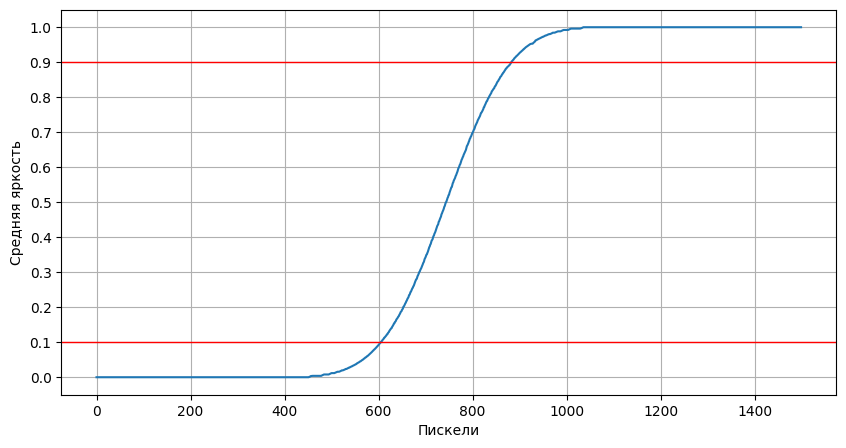

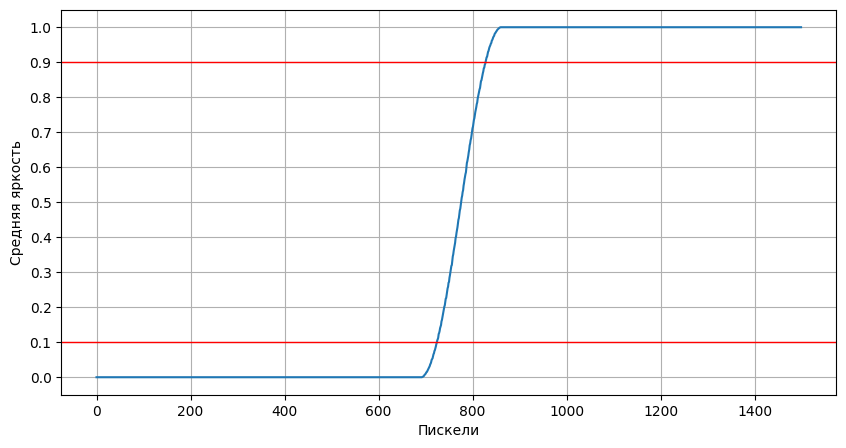

In [24]:
avgs1 = get_rows_avgs(img1)
avgs2 = get_rows_avgs(img2)

plot_avgs(avgs1)
plot_avgs(avgs2)

In [25]:
start1, finish1, middle1 = find_transition_params(avgs1)
width1 = finish1 - start1
start2, finish2, middle2 = find_transition_params(avgs2)
width2 = finish2 - start2

print("Параметры переходов")
print(f"Переход 1: [{start1}, {finish1}] (ширина: {width1}), центр перехода - {middle1}")
print(f"Переход 2: [{start2}, {finish2}] (ширина: {width2}), центр перехода - {middle2}")

Параметры переходов
Переход 1: [604, 883] (ширина: 279), центр перехода - 744
Переход 2: [724, 828] (ширина: 104), центр перехода - 776


(0, 279, 140)
(120, 224, 172)


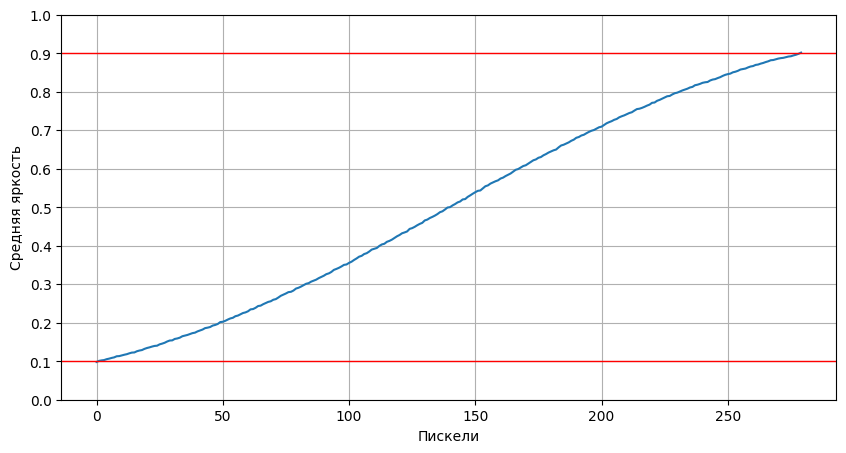

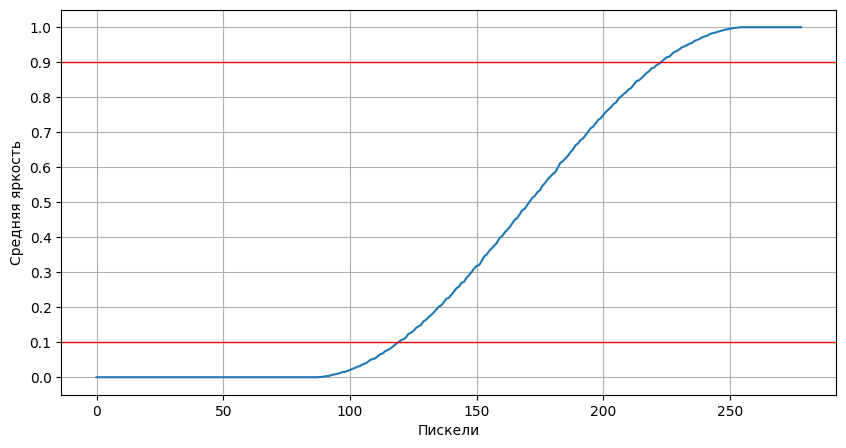

In [26]:
shrinked1 = start_from_zero(shrink_avgs(avgs1, start1, finish1))
shrinked2 = start_from_zero(shrink_avgs(avgs2, start1, finish1))

print(find_transition_params(shrinked1))
print(find_transition_params(shrinked2))

del shrinked2[1][0]
del shrinked2[0][-1]

plot_avgs(shrinked1)
plot_avgs(shrinked2)

In [27]:
start1, finish1, middle1 = find_transition_params(shrinked1)
width1 = finish1 - start1
start2, finish2, middle2 = find_transition_params(shrinked2)
width2 = finish2 - start2

print("Параметры переходов")
print(f"Переход 1: [{start1}, {finish1}] (ширина: {width1}), центр перехода - {middle1}")
print(f"Переход 2: [{start2}, {finish2}] (ширина: {width2}), центр перехода - {middle2}")

Параметры переходов
Переход 1: [0, 279] (ширина: 279), центр перехода - 140
Переход 2: [119, 223] (ширина: 104), центр перехода - 171


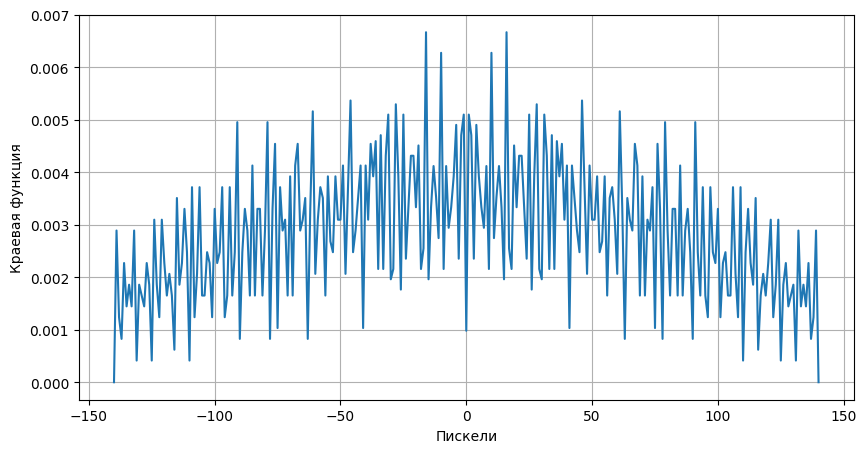

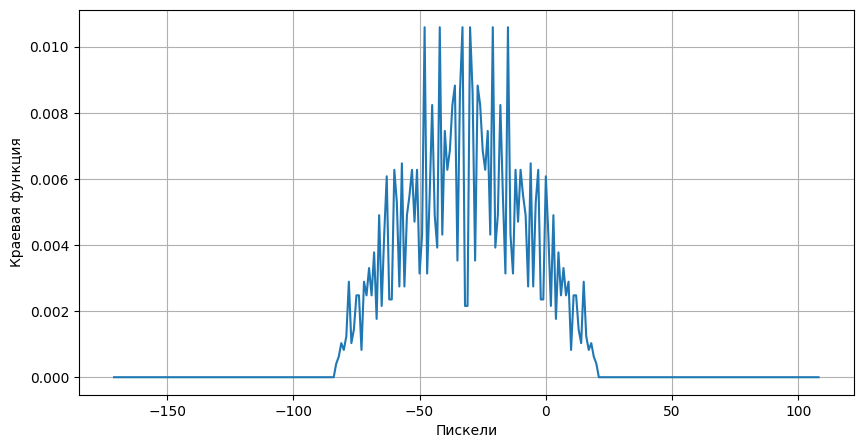

In [28]:
blur1 = align_from_center(get_line_blur(shrinked1))
blur2 = align_from_center(get_line_blur(shrinked2))

plot_line_blur(blur1)
plot_line_blur(blur2)

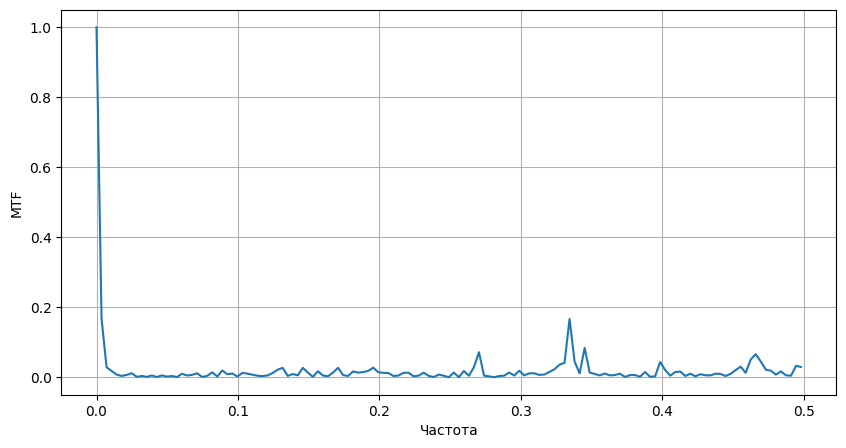

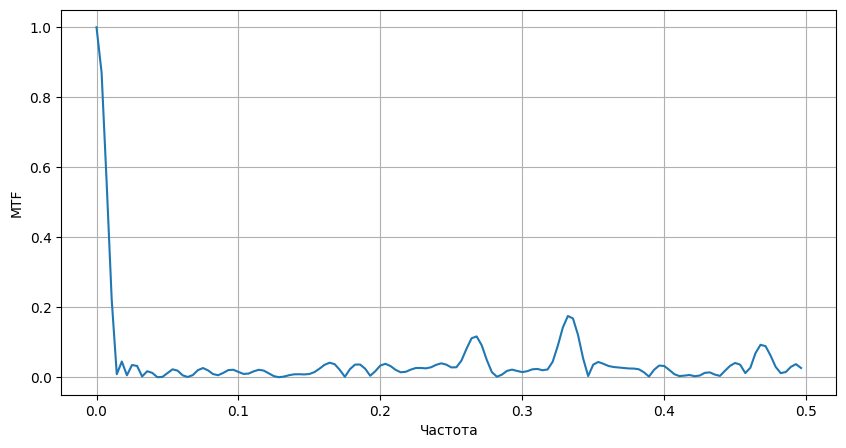

In [29]:
freqs1, mtf1 = calc_MTF(blur1)
freqs2, mtf2 = calc_MTF(blur2)

plot_MTF(freqs1, mtf1)
plot_MTF(freqs2, mtf2)